<a href="https://colab.research.google.com/github/k3rnel-paN1c5/deep-vision/blob/main/KnowledgeDistill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

In [ ]:
# Install TorchDistill (PyTorch-based KD framework)
%pip install torchdistill

# Install PyTorch and dependencies
%pip install torch torchvision

# Install Hugging Face Transformers for model loading
%pip install transformers

# Install dataset tools
%pip install datasets
# for image Processiing
%pip install opencv-python

In [2]:
import torch
import torchvision
from torchvision import transforms
from transformers import AutoModelForDepthEstimation
from transformers import pipeline
import torchdistill
import PIL
import requests
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np


print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("TorchDistill version:", torchdistill.__version__)

PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
TorchDistill version: 1.1.3


In [28]:
# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to("cuda")

# Load student model
student = AutoModelForDepthEstimation.from_pretrained("xingyang1/Distill-Any-Depth-Small-hf").to("cuda")

# Enable gradient checkpointing for teacher and student
teacher.gradient_checkpointing_enable()
student.gradient_checkpointing_enable()


Testing using pipline model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class UnlabeledDepthDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms (match teacher/student input requirements)
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Common depth model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Optimizer
optimizer = optim.AdamW(student.parameters(), lr=3e-4)

# Create dataset/loader
dataset = UnlabeledDepthDataset("/content/drive/MyDrive/images", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [31]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

In [32]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Student prediction
    student_depth_before= student(input_tensor).predicted_depth
    print(student_depth_before.shape)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    print(student_depth_before_training.shape)

torch.Size([1, 378, 378])
(378, 378)


In [42]:
def scale_shift_invariant_loss(student_depth, teacher_depth):
    """
    Computes the scale-and-shift invariant loss between student and teacher depth maps.
    """
    B, H, W = student_depth.shape
    student = student_depth.view(B, -1)  # (B, H*W)
    teacher = teacher_depth.view(B, -1)

    # Create design matrix A = [student_values, 1]
    ones = torch.ones_like(student)  # (B, H*W)
    A = torch.stack([student, ones], dim=2)  # (B, H*W, 2)

    # Solve for optimal alpha (scale) and beta (shift)
    solution = torch.linalg.lstsq(A, teacher.unsqueeze(2)).solution  # (B, 2, 1)
    alpha = solution[:, 0, 0].view(B, 1, 1)
    beta = solution[:, 1, 0].view(B, 1, 1)

    # Align student depth and compute L1 loss
    aligned_student = alpha * student_depth + beta
    loss = torch.mean(torch.abs(aligned_student - teacher_depth))
    return loss

In [37]:
def gradient_matching_loss(student_depth, teacher_depth):
    # Horizontal gradients
    student_grad_x = torch.abs(student_depth[:, :, 1:] - student_depth[:, :, :-1])
    teacher_grad_x = torch.abs(teacher_depth[:, :, 1:] - teacher_depth[:, :, :-1])

    # Vertical gradients
    student_grad_y = torch.abs(student_depth[:, 1:, :] - student_depth[:, :-1, :])
    teacher_grad_y = torch.abs(teacher_depth[:, 1:, :] - teacher_depth[:, :-1, :])

    # Use mean instead of sum to normalize by spatial dimensions
    loss_x = torch.mean(torch.abs(student_grad_x - teacher_grad_x))
    loss_y = torch.mean(torch.abs(student_grad_y - teacher_grad_y))
    return loss_x + loss_y

In [39]:
# Define loss (KL Divergence)
temperature = 4.0
soft_loss = nn.KLDivLoss(reduction="batchmean")

# Define loss weights
alpha_distill = 1.0  # Weight for KL divergence
beta_ssi = 0.5       # Weight for scale-and-shift loss
gamma_gm = 0.5       # Weight for gradient matching loss


In [ ]:
# Training loop
teacher.eval()  # Teacher is frozen
student.train()

In [45]:

for epoch in range(50):
    for batch in dataloader:
        inputs = batch.to("cuda")

        # Teacher forward pass (no gradients)
        with torch.no_grad():

            teacher_outputs = teacher(inputs).predicted_depth

        # Student forward pass
        student_outputs = student(inputs).predicted_depth


        # Distillation loss (soft targets)
        soft_targets = nn.functional.softmax(teacher_outputs / temperature, dim=1)
        student_log_probs = nn.functional.log_softmax(student_outputs / temperature, dim=1)
        distill_loss = soft_loss(student_log_probs, soft_targets) * (temperature ** 2)

        # Scale-and-shift invariant loss
        ssi_loss = scale_shift_invariant_loss(student_outputs, teacher_outputs)

        # Gradient matching loss
        gm_loss = gradient_matching_loss(student_outputs, teacher_outputs)

        total_loss = (
            alpha_distill * distill_loss
            #  + beta_ssi * ssi_loss #! commented this because memory is not sufficent
             +  gamma_gm * gm_loss
        )

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/50 | Loss: {total_loss.item():.4f}")

Epoch 1/50 | Loss: 17469.5820
Epoch 2/50 | Loss: 16177.2295
Epoch 3/50 | Loss: 9952.5693
Epoch 4/50 | Loss: 12441.0127
Epoch 5/50 | Loss: 14187.2637
Epoch 6/50 | Loss: 15153.2822
Epoch 7/50 | Loss: 7538.8252
Epoch 8/50 | Loss: 10795.4404
Epoch 9/50 | Loss: 16269.5410
Epoch 10/50 | Loss: 16294.0645
Epoch 11/50 | Loss: 9919.9590
Epoch 12/50 | Loss: 15462.9512
Epoch 13/50 | Loss: 11541.2920
Epoch 14/50 | Loss: 10081.7676
Epoch 15/50 | Loss: 18104.6660
Epoch 16/50 | Loss: 10568.8613
Epoch 17/50 | Loss: 9387.3281
Epoch 18/50 | Loss: 9334.4033
Epoch 19/50 | Loss: 3245.7029
Epoch 20/50 | Loss: 20803.6055
Epoch 21/50 | Loss: 1842.7637
Epoch 22/50 | Loss: 12954.0684
Epoch 23/50 | Loss: 11472.6934
Epoch 24/50 | Loss: 9159.2051
Epoch 25/50 | Loss: 16180.7773
Epoch 26/50 | Loss: 8785.4521
Epoch 27/50 | Loss: 4687.0054
Epoch 28/50 | Loss: 6029.9365
Epoch 29/50 | Loss: 10952.0449
Epoch 30/50 | Loss: 4258.8770
Epoch 31/50 | Loss: 1585.0546
Epoch 32/50 | Loss: 7563.6997
Epoch 33/50 | Loss: 17746.8809


In [46]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Teacher prediction
    teacher_depth = teacher(input_tensor).predicted_depth.squeeze().cpu().numpy()

    # Student prediction
    student_depth = student(input_tensor).predicted_depth.squeeze().cpu().numpy()

# Before Training

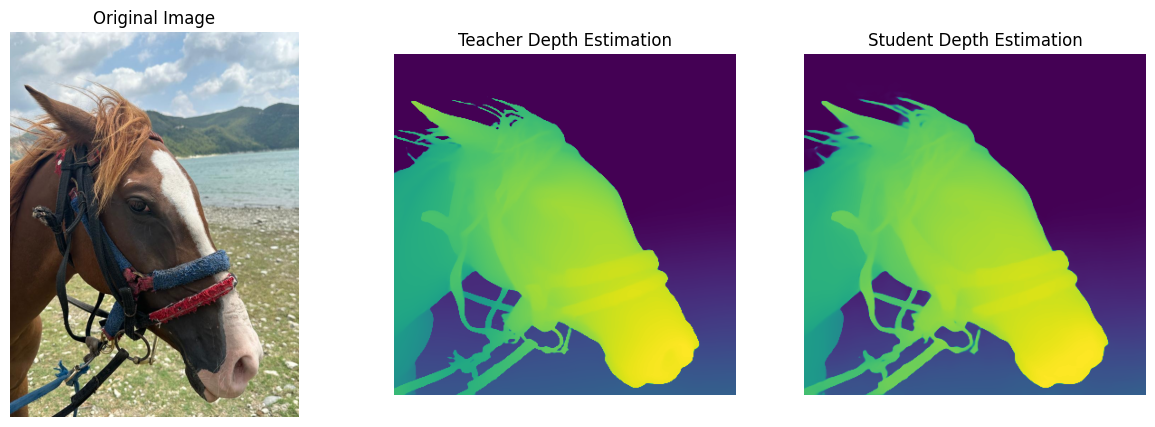

In [47]:
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

# After Training

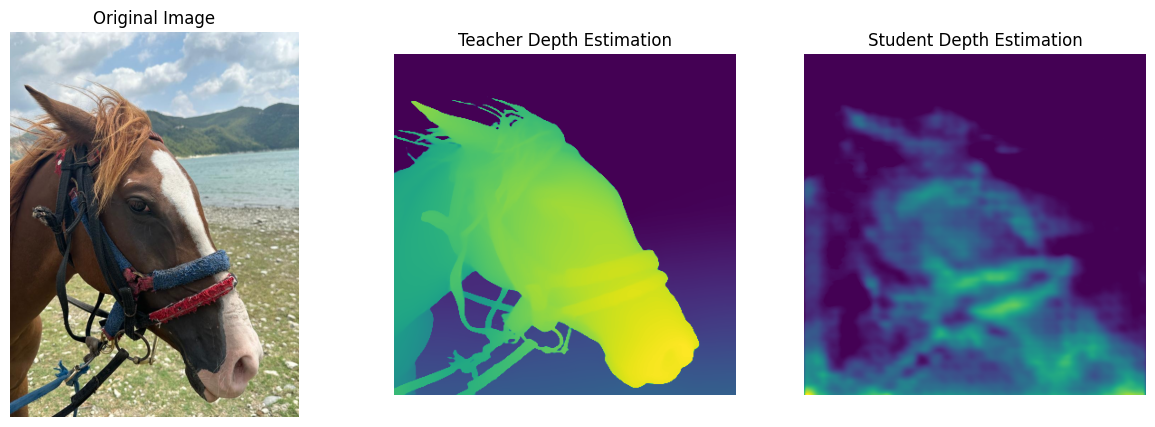

In [48]:
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
# from torchdistill.train.util import train_one_epoch

for epoch in range(50):
    for batch in dataloader:
        inputs = batch.to("cuda")

        # Forward passes
        with torch.no_grad():
            teacher_outputs = teacher(inputs).predicted_depth

        student_outputs = student(inputs).predicted_depth

        # Compute loss
        total_loss = nn.functional.mse_loss(student_outputs, teacher_outputs)

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/50 | Loss: {total_loss.item():.4f}")